In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_fixed_dt.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho_fixed_dt.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T_fixed_dt.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho.txt").reshape((-1,nnt), order = 'F')
moving_mesh = np.loadtxt("../DATA/Fsi_Results/results_mesh.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1.2

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = ROM(rom="pod")
pod.decompose(X, alg="svd",)

In [5]:
rank = 4
rec_X = pod.approximate(rank)

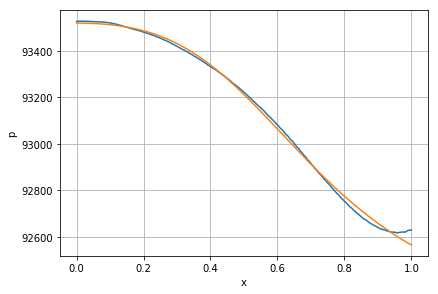

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

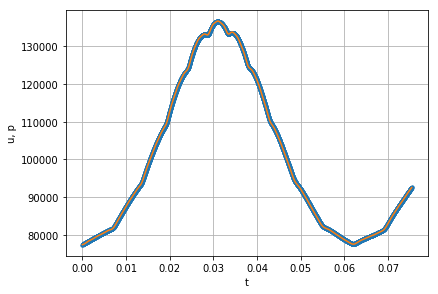

In [7]:
plt.plot(t, X[-1, :], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**Interpolate to fixed time intervals**

In [8]:
ntt = 100
dt = t[-1] / ntt
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T

In [9]:
# Training data
X = np.concatenate((target_fl_m_mesh, target_fl_pressure, target_fl_velocity))[:, :-1]
Y = np.concatenate((target_fl_m_mesh, target_fl_pressure, target_fl_velocity))[:, 1::]

**DMD reduction on velocity**

In [10]:
rank = 0
dmd = ROM("dmd")
dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")

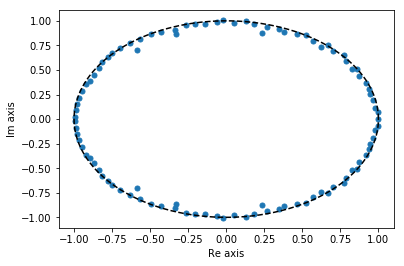

In [11]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 10);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## Reconstructing X

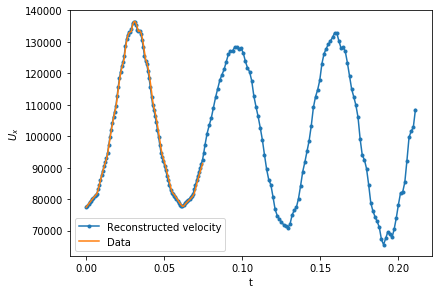

In [12]:
prediction_t = np.concatenate((target_t, np.linspace(target_t[-1] + dt, 2.8 * target_t[-1], int(ntt))))
predicted_X = np.real(dmd.dmd_predict(prediction_t, t[0]))

plt.plot(prediction_t, predicted_X[2 * nx-1, :], '.-', label = "Reconstructed velocity")
plt.plot(target_t[:-1], X[2 * nx-1, :], '-', label = "Data");
plt.legend();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("$U_x$");